In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.fm97 import Na, K, KA, KCa, Ca, CaNernstReversal, Leak, CaPump
import jaxley as jx
from jaxley import Compartment


In [2]:
class Compartment(Compartment):
    """
    Extend the Compartment class to include a voltage clamp method.
    """

    def voltage_clamp(
        self, V_hold1: float, V_step: float, T_hold1: int, T_step: int, dt: float,
        V_hold2: Optional[float] = None, T_hold2: Optional[int] = None,
        init_params = None,
    ) -> Tuple[
        Dict[str, jnp.ndarray], Dict[str, Dict[str, jnp.ndarray]]
    ]:
        """
        Apply a voltage clamp to the Compartment and record the resulting currents and state changes.

        Args:
            V_hold1: The first holding voltage in mV.
            V_step: The step voltage in mV.
            T_hold1: The duration of the first holding voltage in time steps.
            T_step: The duration of the step voltage in time steps.
            dt: The time step in ms.
            V_hold2: The second holding voltage in mV (optional, defaults to V_hold1).
            T_hold2: The duration of the second holding voltage in time steps (optional, defaults to T_hold1).

        Returns:
            A tuple containing a dictionary for the currents and a dictionary for the state histories.
        """
        if V_hold2 is None:
            V_hold2 = V_hold1
        if T_hold2 is None:
            T_hold2 = T_hold1

        # Initialize the global state and dictionaries for currents and states
        params = {}
        states = {}
        channel_currents = {
            "hold1": {channel._name: [] for channel in self.channels},
            "step": {channel._name: [] for channel in self.channels},
            "hold2": {channel._name: [] for channel in self.channels},
        }
        channel_states_history = {
            "hold1": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "step": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "hold2": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
        }

        for channel in self.channels:
            states.update(channel.channel_states)
            params.update(channel.channel_params)

        if init_params is not None:
            params.update(init_params)
        
        # self.to_jax()

        def update_all_channels(V, dt, phase):
            for channel in self.channels:
                # Compute and store the current for the channel
                current = channel.compute_current(states, V, params)
                states[f"i{channel._name}"] = current
                channel_currents[phase][channel._name].append(current)
            
                # Update the states
                new_states = channel.update_states(states, dt, V, params)
                if channel == "CaNernstReversal":
                    print(new_states)
                states.update(new_states)
                for state_key, state_value in new_states.items():
                    channel_states_history[phase][channel._name][state_key].append(state_value)

        # First hold phase
        for _ in range(T_hold1):
            update_all_channels(V_hold1, dt, "hold1")

        # Step phase
        for _ in range(T_step):
            update_all_channels(V_step, dt, "step")

        # Second hold phase
        for _ in range(T_hold2):
            update_all_channels(V_hold2, dt, "hold2")

        # Convert lists to jnp.ndarray and merge all phases
        merged_currents = {}
        for channel_name in channel_currents["hold1"]:
            merged_currents[channel_name] = jnp.concatenate([
                jnp.array(channel_currents["hold1"][channel_name]),
                jnp.array(channel_currents["step"][channel_name]),
                jnp.array(channel_currents["hold2"][channel_name])
            ])

        merged_states_history = {}
        for channel_name in channel_states_history["hold1"]:
            merged_states_history[channel_name] = {}
            for state_name in channel_states_history["hold1"][channel_name]:
                merged_states_history[channel_name][state_name] = jnp.concatenate([
                    jnp.array(channel_states_history["hold1"][channel_name][state_name]),
                    jnp.array(channel_states_history["step"][channel_name][state_name]),
                    jnp.array(channel_states_history["hold2"][channel_name][state_name])
                ])

        return merged_currents, merged_states_history

In [3]:
params = {
    # conductance
    "Na_gNa": 0.04,
    "K_gK": 0.012,
    "KA_gKA": 0.036,
    "Ca_gCa": 0.0022,
    "KCa_gKCa": 0.00005,
    "Leak_gLeak": 0.00005,

    # reversal potential
    "Na_eNa": 35,
    "Leak_eLeak": -65,

    # Ca dynamics
    "Cao": 1.8,

    # pump
    "CaPump_taur": 10.,
    "CaPump_cainf": 0.0001,

    # global
    "length": 25.,
    "radius": 25/2, 
    "eK": -75,
}

cell = Compartment()

cell.insert(Na())
cell.insert(Ca())
cell.insert(K())
cell.insert(KCa())
cell.insert(KA())
cell.insert(CaNernstReversal())
cell.insert(CaPump())
cell.insert(Leak())

for name, param in params.items():
    cell.set(name, param)

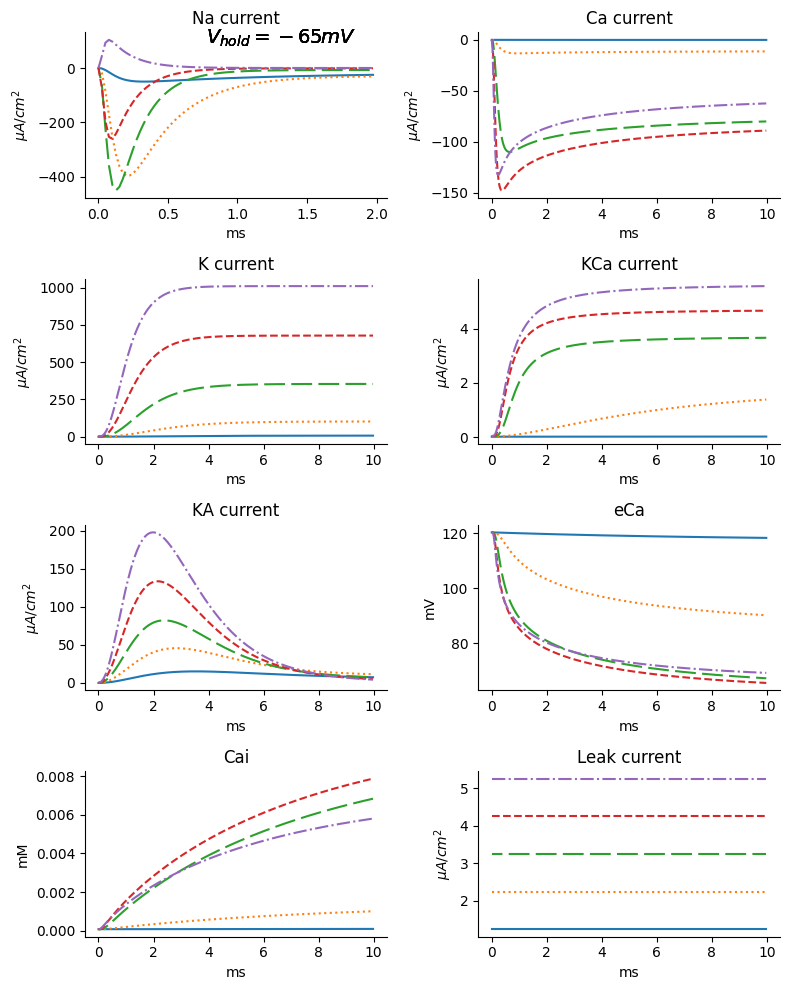

In [4]:
V_hold = -65.0  # mV, the holding potential

dt = 0.025    # ms, the time step for the simulation
t_hold = 10 # ms
t_step = 10 # ms
T_hold = int(t_hold / dt) # points
T_step = int(t_step / dt) # points
fig, ax = plt.subplots(4, 2, figsize=(8,10))
ax = ax.flatten()

linestyles = {
	"-40": "solid",
	"-20": "dotted",
	"0": (5, (10, 3)),
	"20": "dashed",
	"40": "dashdot",
}

# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 0  # ms
post_step_duration = 0  # ms

pre_step_indices = int(pre_step_duration // dt)
post_step_indices = int(post_step_duration // dt)

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices
time_window = jnp.arange(-pre_step_duration, t_step + post_step_duration, dt)


for V_step in [-40, -20, 0, 20, 40]:
    currents, states = cell.voltage_clamp(V_hold1=V_hold, T_hold1=T_hold, V_step=V_step,  T_step=T_step, dt=dt, init_params=params)

    ax = ax.flatten()
    
    for i, key in enumerate(currents):
        if key == "CaPump":
            ax[i].plot(time_window, states["CaPump"]["Cai"][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title("Cai")
            ax[i].set_ylabel("mM")
        elif key == "CaNernstReversal":
            ax[i].plot(time_window, states["CaNernstReversal"]["eCa"][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title("eCa")
            ax[i].set_ylabel("mV")
        else:
            if key == "Na":
                time_window_na = jnp.arange(-pre_step_duration, 2, dt)
                ax[i].plot(time_window_na, currents[key][start_step_index:start_step_index+int(2/dt)], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            else:
                ax[i].plot(time_window, currents[key][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title(key + " current")
            ax[i].set_ylabel(r"$μA/cm^2$")

        ax[i].set_xlabel("ms")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)

    ax[0].annotate(r"$V_{hold}=-65 mV$", xy=(0.9, 0.9), xycoords="axes fraction", ha="right", va="bottom", fontsize=14)

fig.tight_layout()

The values (Na and Ca) are still a bit off compared to Fig. 1 in Fohlmeister & Miller (1997). It is primarily due to the parameters reported in Table 1 are not exactly the same one used in the working NEURON code, which is in turn different from the current version hosted on [ModelDB](https://modeldb.science/3673). I have to manually adjust the parameters to get the similar results as in the paper.

The other possible source of discrepancy might stem from the convenient implementation of the built-in Calcium pump in the Calcium channel, while the NEURON implementation relies on a separate Calcium pump (which is again implemented differently from the description in the paper). 

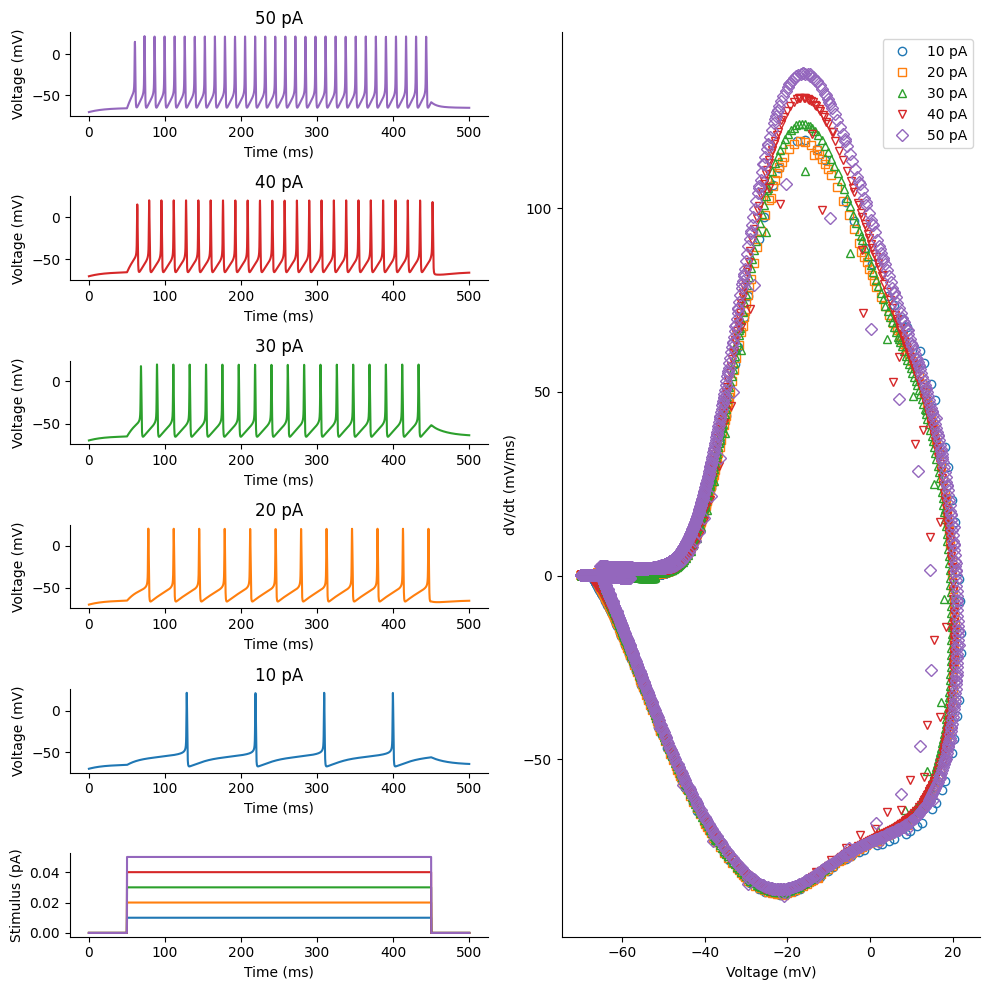

In [5]:
# Fig. 4

# Stimulus.
i_delay = 50.0  # ms
i_dur = 400.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 0.1  # ms
t_max = i_dur + 2 * i_delay  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

mosaic = """
    AAAAAGGGGG
    BBBBBGGGGG
    CCCCCGGGGG
    DDDDDGGGGG
    EEEEEGGGGG
    FFFFFGGGGG
"""
mappings = {
    0: "E",
    1: "D",
    2: "C",
    3: "B",
    4: "A",
    5: "F",
    6: "G",
}
markers = {
    4: "D",
    3: "v",
    2: "^",
    1: "s",
    0: "o",
}

# params = {
#     # conductance
#     "Na_gNa": 0.04,
#     "K_gK": 0.012,
#     "KA_gKA": 0.036,
#     "Ca_gCa": 0.0022,
#     "KCa_gKCa": 0.00005,
#     "Leak_gLeak": 0.00005,

#     # reversal potential
#     "Na_eNa": 35,
#     "Leak_eLeak": -60,

#     # Ca dynamics, this is actually a state variable
#     "Cai": 0.0001,

#     # global
#     "length": 25.,
#     "radius": 25/2,
#     "eK": -75,
# }


fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(10, 10))

for j, i_amp in enumerate([0.01, 0.02, 0.03, 0.04, 0.05]): 

    cell = Compartment()

    cell.insert(Na())
    cell.insert(Ca())
    cell.insert(K())
    cell.insert(KCa())
    cell.insert(KA())
    cell.insert(CaNernstReversal())
    cell.insert(CaPump())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
    cell.stimulate(current, verbose=False)
    cell.record(verbose=False)

    # run the model
    s = jx.integrate(cell, delta_t=dt)

    _ = ax[mappings[j]].plot(time_vec, s.T[:-1], label=f"{int(i_amp*1000)} pA", color=f"C{j}")
    _ = ax[mappings[j]].set_xlabel("Time (ms)")
    _ = ax[mappings[j]].set_ylabel("Voltage (mV)")
    _ = ax[mappings[j]].set_title(f"{int(i_amp*1000)} pA")
    _ = ax[mappings[j]].spines["top"].set_visible(False)
    _ = ax[mappings[j]].spines["right"].set_visible(False)

    _ = ax["F"].plot(time_vec, current, label=f"{int(i_amp*1000)} pA")
    _ = ax["F"].set_xlabel("Time (ms)")
    _ = ax["F"].set_ylabel("Stimulus (pA)")
    _ = ax["F"].spines["top"].set_visible(False)
    _ = ax["F"].spines["right"].set_visible(False)

    dvdt = jnp.diff(s.T.flatten()) / dt
    _ = ax["G"].plot(s.T.flatten()[:-1], dvdt, marker=markers[j], markerfacecolor='None', linestyle='None', label=f"{int(i_amp*1000)} pA", color=f"C{j}")
    _ = ax["G"].set_xlabel("Voltage (mV)")
    _ = ax["G"].set_ylabel("dV/dt (mV/ms)")
    _ = ax["G"].spines["top"].set_visible(False)
    _ = ax["G"].spines["right"].set_visible(False)

ax["G"].legend()
fig.tight_layout()

In [6]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-05-23 11:54:28CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.0.1

jaxley    : 0.0.0
jax       : 0.4.26
matplotlib: 3.8.3

Watermark: 2.4.3

